1. Explore weather data****

In the Explorer pane of the BigQuery console, expand bigquery-public-data > noaa_gsod and select the gsod2014 table.

In [ ]:
SELECT
  -- Create a timestamp from the date components.
  stn,
  TIMESTAMP(CONCAT(year,"-",mo,"-",da)) AS timestamp,
  -- Replace numerical null values with actual null
  AVG(IF (temp=9999.9,
      null,
      temp)) AS temperature,
  AVG(IF (wdsp="999.9",
      null,
      CAST(wdsp AS Float64))) AS wind_speed,
  AVG(IF (prcp=99.99,
      0,
      prcp)) AS precipitation
FROM
  `bigquery-public-data.noaa_gsod.gsod20*`
WHERE
  CAST(YEAR AS INT64) > 2010
  AND CAST(MO AS INT64) = 6
  AND CAST(DA AS INT64) = 12
  AND (stn="725030" OR  -- La Guardia
    stn="744860")    -- JFK
GROUP BY
  stn,
  timestamp
ORDER BY
  timestamp DESC,
  stn ASC

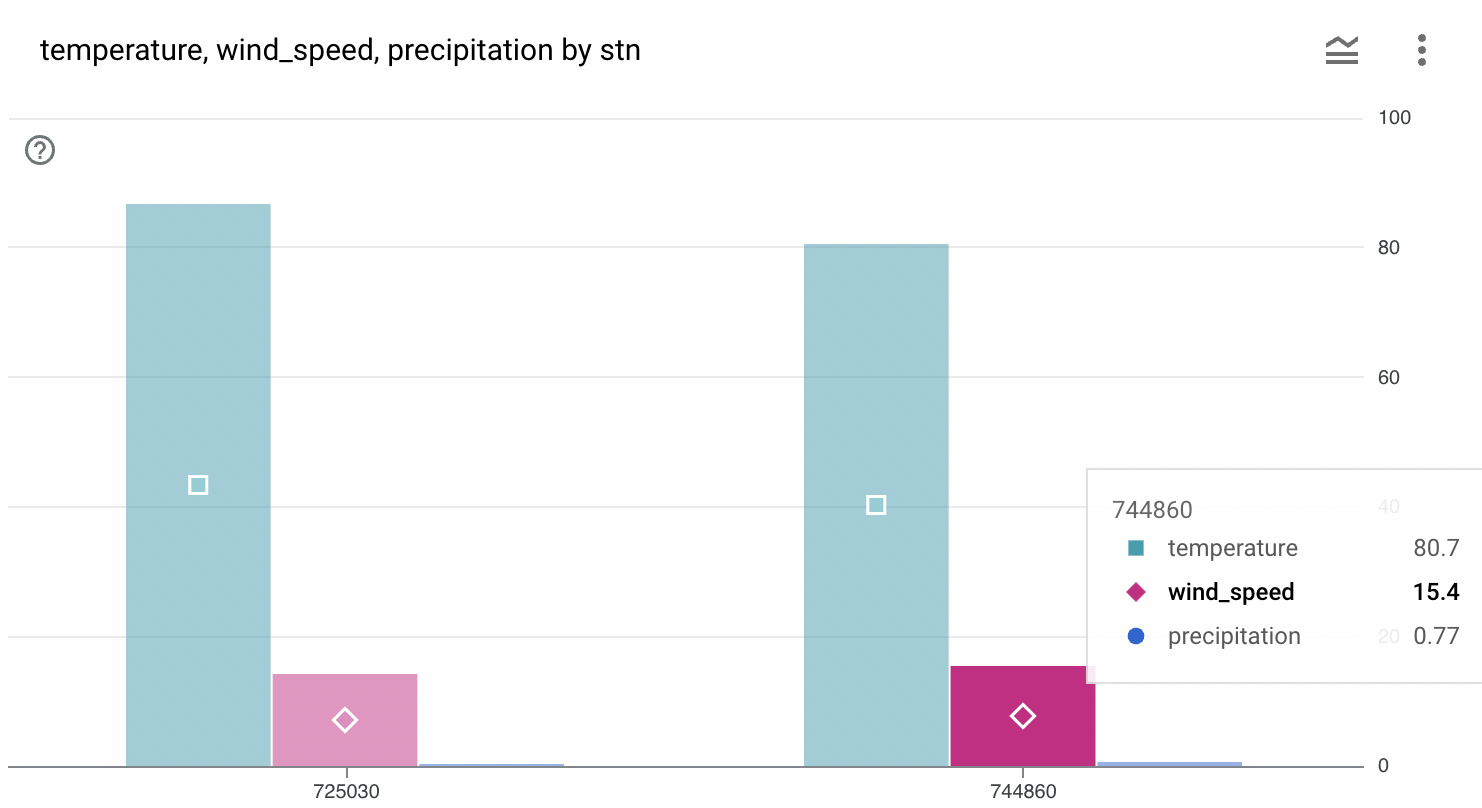

https://docs.google.com/spreadsheets/d/1_3p1DO6fNyIOH5rR3t8LBUzIQNxOVWIkeWkMmKiCCaI/edit?usp=sharing

2. Explore New York citizen complaints data

In the Explorer pane of the BigQuery Console, select the newly added bigquery-public-data project and expand the new_york dataset and select 311_service_requests table.

In [ ]:
SELECT
  EXTRACT(YEAR
  FROM
    created_date) AS year,
  complaint_type,
  COUNT(1) AS num_complaints
FROM
  `bigquery-public-data.new_york.311_service_requests`
GROUP BY
  year,
  complaint_type
ORDER BY
  num_complaints DESC

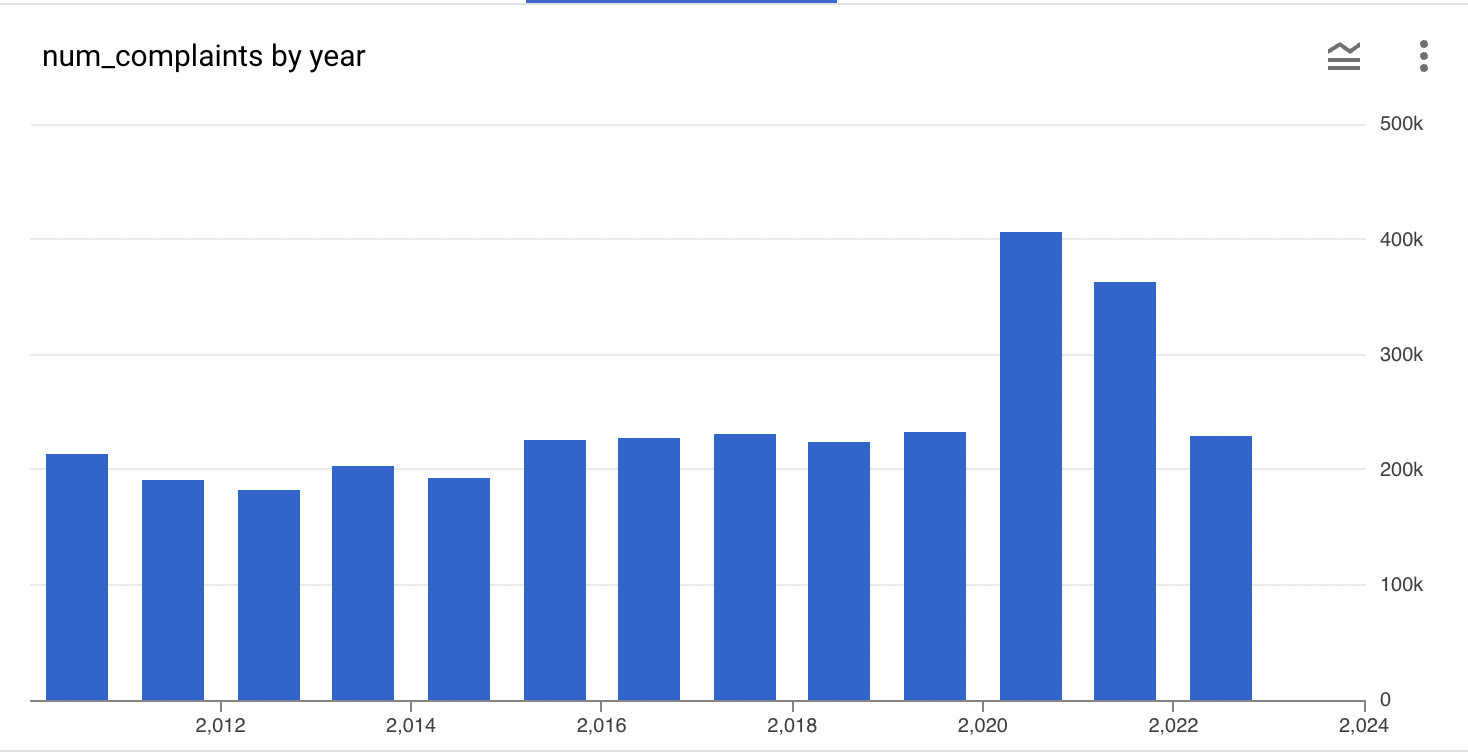

https://docs.google.com/spreadsheets/d/12S5qlqKgFGe0NB8NBy0jAf4GbGxcwjiUtSJlXNz_New/edit?usp=sharing

3. Saving a new table of weather data****

1. In the Explorer pane of the BigQuery Console, click on the three dots next to your Project ID and then select Create dataset.
2. In the Create dataset dialog, set the Dataset ID to demos and leave the other options at their default values.
3. Click Create dataset. Your project now has a dataset named demos.

In [ ]:
SELECT
  -- Create a timestamp from the date components.
  timestamp(concat(year,"-",mo,"-",da)) as timestamp,
  -- Replace numerical null values with actual nulls
  AVG(IF (temp=9999.9, null, temp)) AS temperature,
  AVG(IF (visib=999.9, null, visib)) AS visibility,
  AVG(IF (wdsp="999.9", null, CAST(wdsp AS Float64))) AS wind_speed,
  AVG(IF (gust=999.9, null, gust)) AS wind_gust,
  AVG(IF (prcp=99.99, null, prcp)) AS precipitation,
  AVG(IF (sndp=999.9, null, sndp)) AS snow_depth
FROM
  `bigquery-public-data.noaa_gsod.gsod20*`
WHERE
  CAST(YEAR AS INT64) > 2008
  AND (stn="725030" OR  -- La Guardia
       stn="744860")    -- JFK
GROUP BY timestamp

In the query EDITOR section, click More > Query settings.

In the Query settings dialog, set the following fields. Leave all others at their default value.

Destination: select Set a destination table for query results

Dataset: Type demos and select your dataset.

Table Id: Type nyc_weather

Results size: check Allow large results (no size limit)

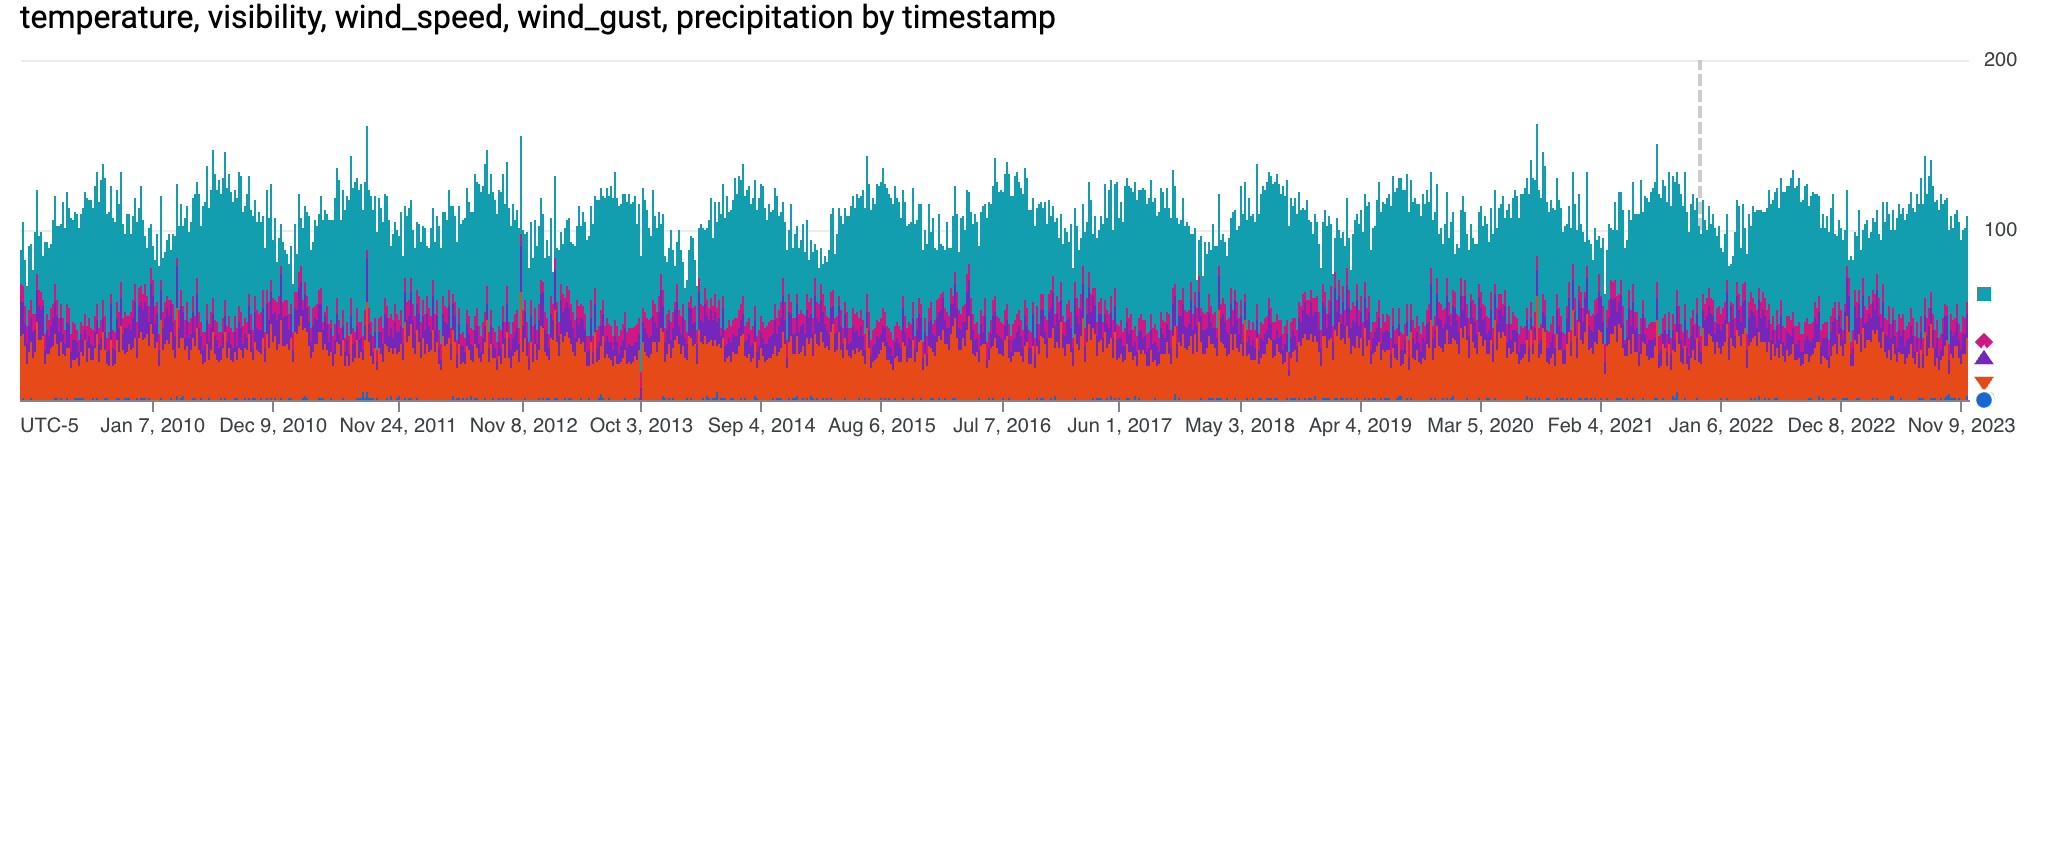

https://docs.google.com/spreadsheets/d/1s6sUXMulErCiTMXMaISjf86728o2ggdXkB-57kj-PKI/edit?usp=sharing

* Blue: precipitation
* Teal: temperature
* Pink: visibility
* Orange: wind_gust
* Purple: wind_speed

4. Find correlation between weather and complaints****

Compare the number of complaints and temperature using the CORR function.

In [ ]:
SELECT
  descriptor,
  sum(complaint_count) as total_complaint_count,
  count(temperature) as data_count,
  ROUND(corr(temperature, avg_count),3) AS corr_count,
  ROUND(corr(temperature, avg_pct_count),3) AS corr_pct
From (
SELECT
  avg(pct_count) as avg_pct_count,
  avg(day_count) as avg_count,
  sum(day_count) as complaint_count,
  descriptor,
  temperature
FROM (
  SELECT
    DATE(timestamp) AS date,
    temperature
  FROM
    demos.nyc_weather) a
  JOIN (
  SELECT x.date, descriptor, day_count, day_count / all_calls_count as pct_count
  FROM
    (SELECT
      DATE(created_date) AS date,
      concat(complaint_type, ": ", descriptor) as descriptor,
      COUNT(*) AS day_count
    FROM
      `bigquery-public-data.new_york.311_service_requests`
    GROUP BY
      date,
      descriptor)x
    JOIN (
      SELECT
        DATE(timestamp) AS date,
        COUNT(*) AS all_calls_count
      FROM `demos.nyc_weather`
      GROUP BY date
    )y
  ON x.date=y.date
)b
ON
  a.date = b.date
GROUP BY
  descriptor,
  temperature
)
GROUP BY descriptor
HAVING
  total_complaint_count > 5000 AND
  ABS(corr_pct) > 0.5 AND
  data_count > 5
ORDER BY
  ABS(corr_pct) DESC

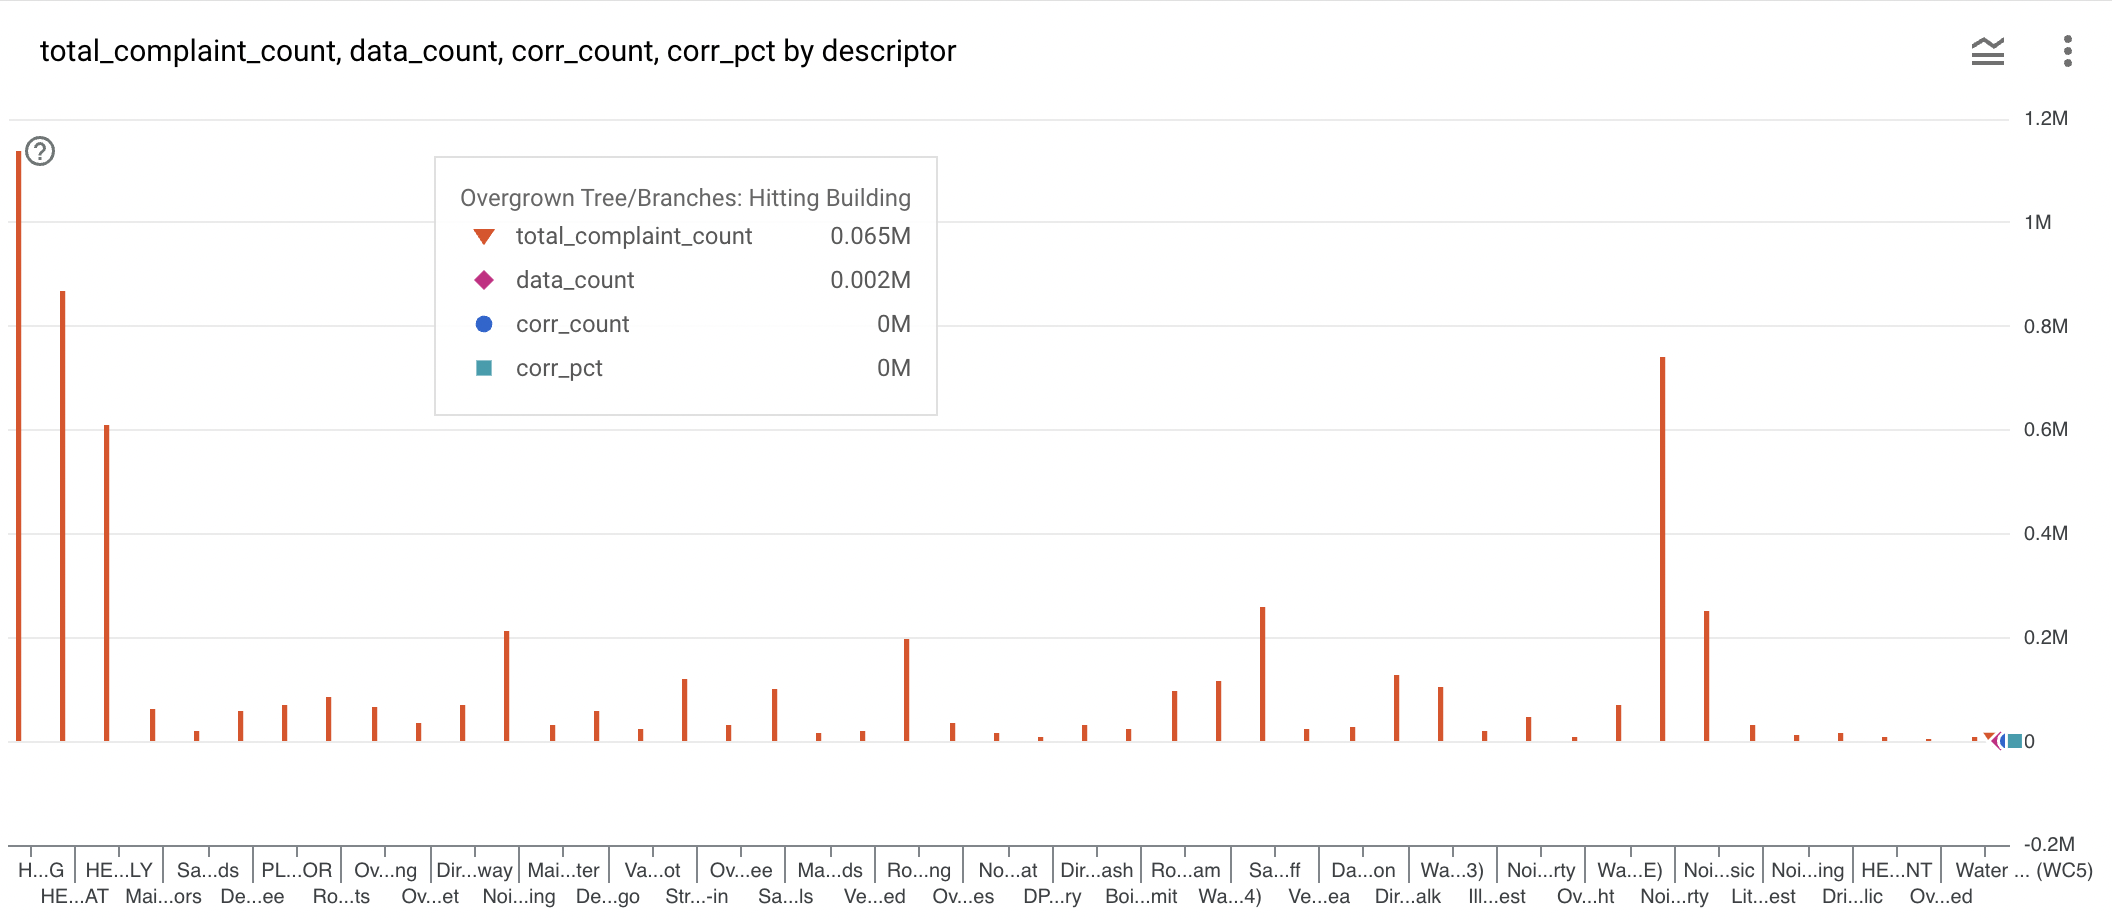

https://docs.google.com/spreadsheets/d/1HZk7nDmsCPPEfHlj2GA__SAb-DoGDciny9K_k6n98YQ/edit?usp=sharing

The results indicate that Heating complaints are negatively correlated with temperature (i.e., more heating calls on cold days) and calls about dead trees are positively correlated with temperature (i.e., more calls on hot days).

Compare the number of complaints and wind speed with the CORR function.



In [ ]:
SELECT
  descriptor,
  sum(complaint_count) as total_complaint_count,
  count(wind_speed) as data_count,
  ROUND(corr(wind_speed, avg_count),3) AS corr_count,
  ROUND(corr(wind_speed, avg_pct_count),3) AS corr_pct
From (
SELECT
  avg(pct_count) as avg_pct_count,
  avg(day_count) as avg_count,
  sum(day_count) as complaint_count,
  descriptor,
  wind_speed
FROM (
  SELECT
    DATE(timestamp) AS date,
    wind_speed
  FROM
    demos.nyc_weather) a
  JOIN (
  SELECT x.date, descriptor, day_count, day_count / all_calls_count as pct_count
  FROM
    (SELECT
      DATE(created_date) AS date,
      concat(complaint_type, ": ", descriptor) as descriptor,
      COUNT(*) AS day_count
    FROM
      `bigquery-public-data.new_york.311_service_requests`
    GROUP BY
      date,
      descriptor)x
    JOIN (
      SELECT
        DATE(timestamp) AS date,
        COUNT(*) AS all_calls_count
      FROM `demos.nyc_weather`
      GROUP BY date
    )y
  ON x.date=y.date
)b
ON
  a.date = b.date
GROUP BY
  descriptor,
  wind_speed
)
GROUP BY descriptor
HAVING
  total_complaint_count > 5000 AND
  ABS(corr_pct) > 0.5 AND
  data_count > 5
ORDER BY
  ABS(corr_pct) DESC

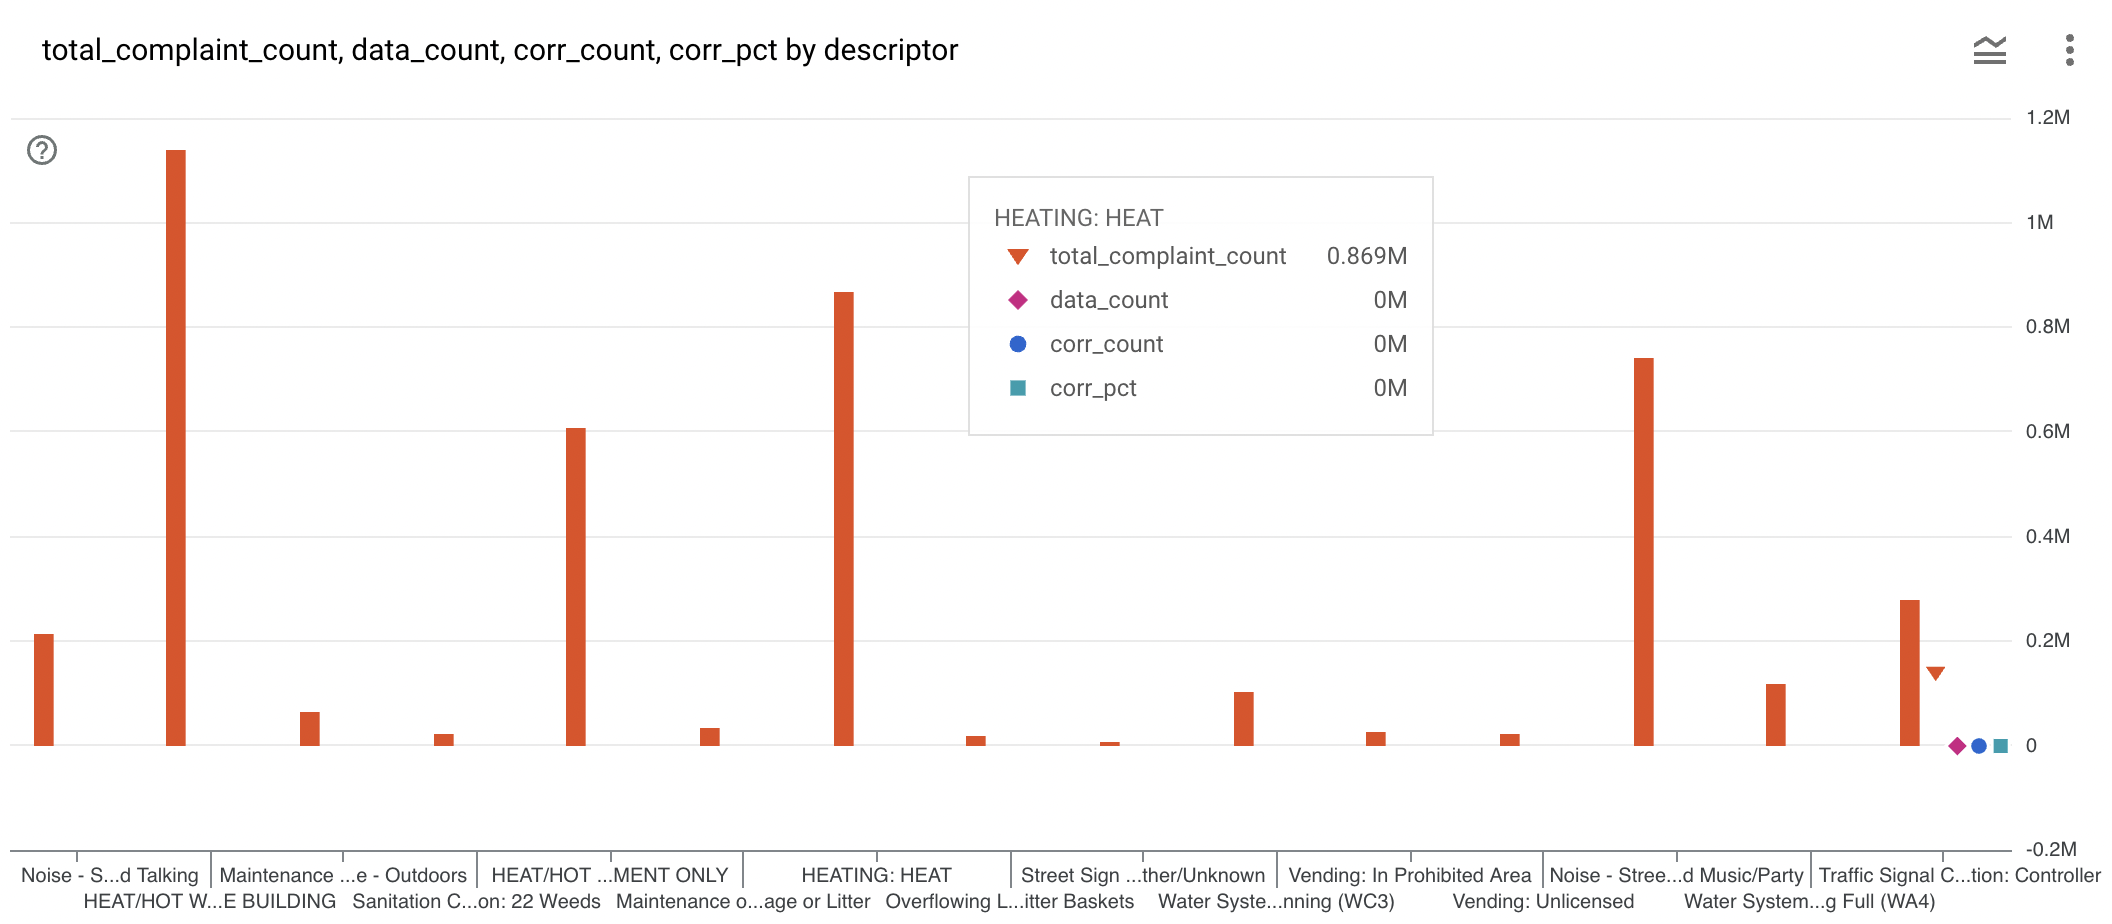

https://docs.google.com/spreadsheets/d/1lnLMY3TkaxGw9ZNxXZfL7RkBzrvNY_meYsVR9V6Czj8/edit?usp=sharing

The correlation data suggests a moderate negative relationship between wind and noise complaints. This implies that on windier days, noise complaints decrease, possibly due to the wind reducing outdoor activities. Statistical significance requires further analysis.